#Getting dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K

#Loading and preprocessing images

In [ ]:
def load_images(folder_path, img_size=(224, 224)):
    data = []
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            data.append(img_array)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return np.array(data)

#Dataset paths

In [ ]:
dataset_path = "/content/drive/MyDrive/Sentiment classifier"
happy_folder = os.path.join(dataset_path, "happy")
sad_folder = os.path.join(dataset_path, "sad")

#Loading the data according to what we have in the dataset

In [ ]:
happy_images = load_images(happy_folder)
sad_images = load_images(sad_folder)

#Augmentation for minority class which should be the sad

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)


#Balance dataset cause happy is like double of sad so i'm generating more images from existing ones by rotatinng, increasing contrast and all but i also added the while loop so i don't have more sad than happy i want them to be equal


In [ ]:
required_augmented_sad = len(happy_images) - len(sad_images)
augmented_sad_images = []
while len(augmented_sad_images) < required_augmented_sad:
    img = np.expand_dims(sad_images[np.random.randint(len(sad_images))], axis=0)
    aug_iter = train_datagen.flow(img, batch_size=1)
    augmented_sad_images.append(next(aug_iter)[0])
augmented_sad_images = np.array(augmented_sad_images)

#Combine the data

In [ ]:
X = np.concatenate([happy_images, sad_images, augmented_sad_images], axis=0)
y = np.concatenate([np.ones(len(happy_images)), np.zeros(len(sad_images) + len(augmented_sad_images))], axis=0)
X, y = shuffle(X, y, random_state=42)

#Split the data into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model building

Loss:0.40980470180511475, Accuracy: 0.8125 so i've updated the CNN for better feature extraction, stability and to reduce overfitting by adding an extra layer to the custom CNN

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


With this i got Loss: 0.413732647895813, Accuracy: 0.8068181872367859

In [ ]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])


#Compile

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

#Callbacks

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

#Train

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1,
)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6360
Epoch 1: val_loss improved from inf to 0.61170, saving model to best_model.keras
44/44 [==============================] - 20s 428ms/step - loss: 0.6511 - accuracy: 0.6360 - val_loss: 0.6117 - val_accuracy: 0.7585 - lr: 1.0000e-05
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7258
Epoch 2: val_loss did not improve from 0.61170
44/44 [==============================] - 18s 409ms/step - loss: 0.6460 - accuracy: 0.7258 - val_loss: 0.6160 - val_accuracy: 0.7585 - lr: 1.0000e-05
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.7308
Epoch 3: val_loss improved from 0.61170 to 0.59694, saving model to best_model.keras
44/44 [==============================] - 18s 417ms/step - loss: 0.6355 - accuracy: 0.7308 - val_loss: 0.5969 - val_accuracy: 0.7614 - lr: 1.0000e-05
Epoch 4/30
44/44 [==============================] - ETA: 0

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1,
)

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7301
Epoch 1: val_loss improved from 0.59069 to 0.50557, saving model to best_model.keras
44/44 [==============================] - 18s 409ms/step - loss: 0.5757 - accuracy: 0.7301 - val_loss: 0.5056 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7386
Epoch 2: val_loss improved from 0.50557 to 0.45458, saving model to best_model.keras
44/44 [==============================] - 18s 408ms/step - loss: 0.5281 - accuracy: 0.7386 - val_loss: 0.4546 - val_accuracy: 0.7812 - lr: 1.0000e-05
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.5039 - accuracy: 0.7479
Epoch 3: val_loss improved from 0.45458 to 0.44107, saving model to best_model.keras
44/44 [==============================] - 18s 420ms/step - loss: 0.5039 - accuracy: 0.7479 - val_loss: 0.4411 - val_accuracy: 0.7926 - lr: 1.0000e-05
Epoch 4/20
44/44

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1,
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6268
Epoch 1: val_loss improved from inf to 0.61521, saving model to best_model.keras
44/44 [==============================] - 20s 427ms/step - loss: 0.6543 - accuracy: 0.6268 - val_loss: 0.6152 - val_accuracy: 0.7585 - lr: 1.0000e-05
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.7244
Epoch 2: val_loss improved from 0.61521 to 0.60796, saving model to best_model.keras
44/44 [==============================] - 18s 408ms/step - loss: 0.6485 - accuracy: 0.7244 - val_loss: 0.6080 - val_accuracy: 0.7585 - lr: 1.0000e-05
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.7258
Epoch 3: val_loss improved from 0.60796 to 0.58190, saving model to best_model.keras
44/44 [==============================] - 19s 422ms/step - loss: 0.6284 - accuracy: 0.7258 - val_loss: 0.5819 - val_accuracy: 0.7614 - lr: 1.0000e-05
Epoch 4/50
44/44 [==

#Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

11/11 [==============================] - 1s 77ms/step - loss: 0.4084 - accuracy: 0.8153
Loss: 0.40841805934906006, Accuracy: 0.8153409361839294


#Plot training and validation loss/accuracy

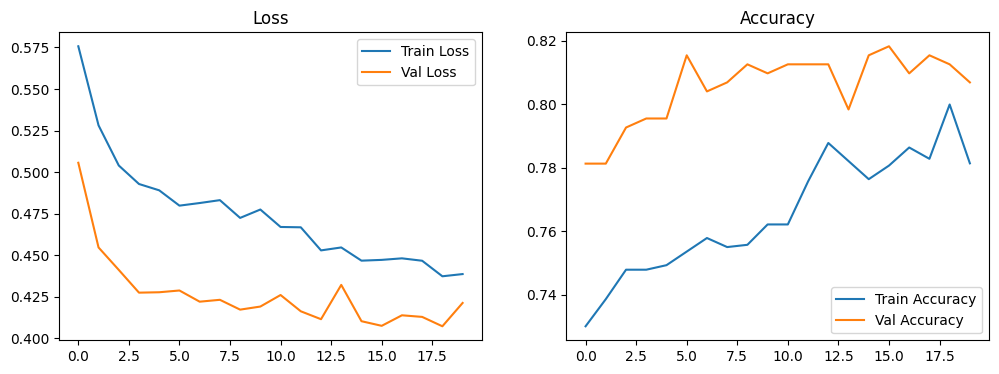

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


#Verify Predictions and plot confusion metrics

11/11 [==============================] - 1s 80ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78       171
         1.0       0.77      0.90      0.83       181

    accuracy                           0.81       352
   macro avg       0.82      0.80      0.80       352
weighted avg       0.82      0.81      0.80       352



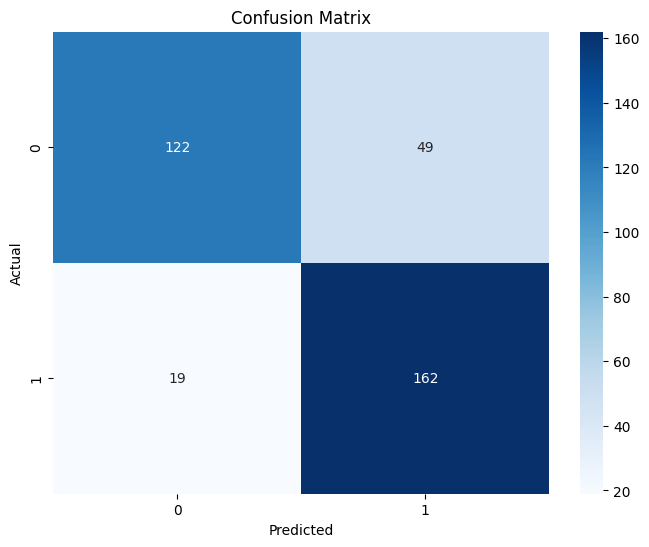

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Grad-CAM example to visualize activations

In [ ]:
def grad_cam(input_model, img_array, layer_name):
    model = tf.keras.models.Model(
        inputs=[input_model.input],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )
    conv_output, predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    grad = K.gradients(predictions[:, class_idx], conv_output)[0]
    pooled_grads = K.mean(grad, axis=(0, 1, 2))
    heatmap = np.mean(conv_output[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


#Save the model

In [ ]:
model.save('emotion_classifier.h5')

#Test if model actually works

In [ ]:
# image_path = "/content/brazilian-boy-smiling.jpg"
image_path = "/content/2d808f8478c2eb1c63605e3ffd961f5d2.jpg"
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

raw_prediction = model.predict(img_array)[0][0]
print(f"Raw prediction: {raw_prediction}")
label = "happy" if raw_prediction > 0.5 else "sad"
confidence = raw_prediction if raw_prediction > 0.5 else 1 - raw_prediction
print(f"Label: {label}, Confidence: {confidence}")

# Feedforward Neural Network (FFNN) Implementation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def create_ffnn(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

ffnn = create_ffnn(X_train.shape[1:])
ffnn.summary()

# Train the Feedforward Neural Network

In [ ]:
history_ffnn = ffnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

def create_improved_ffnn(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

improved_ffnn = create_improved_ffnn(X_train.shape[1:])
history_improved_ffnn = improved_ffnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32
)


Epoch 1/30
44/44 [==============================] - 8s 160ms/step - loss: 8.9764 - accuracy: 0.7115 - val_loss: 6.3643 - val_accuracy: 0.7699
Epoch 2/30
44/44 [==============================] - 6s 145ms/step - loss: 4.5637 - accuracy: 0.7472 - val_loss: 3.2981 - val_accuracy: 0.8097
Epoch 3/30
44/44 [==============================] - 6s 144ms/step - loss: 3.0242 - accuracy: 0.7507 - val_loss: 2.6825 - val_accuracy: 0.7500
Epoch 4/30
44/44 [==============================] - 6s 145ms/step - loss: 2.5919 - accuracy: 0.7571 - val_loss: 2.7071 - val_accuracy: 0.6364
Epoch 5/30
44/44 [==============================] - 6s 146ms/step - loss: 2.4341 - accuracy: 0.7507 - val_loss: 2.9542 - val_accuracy: 0.4858
Epoch 6/30
44/44 [==============================] - 6s 137ms/step - loss: 2.6180 - accuracy: 0.7507 - val_loss: 2.3832 - val_accuracy: 0.8040
Epoch 7/30
44/44 [==============================] - 6s 141ms/step - loss: 2.3204 - accuracy: 0.7464 - val_loss: 2.2054 - val_accuracy: 0.4915
Epoch 

# Compare Performance of FFNN and CNN

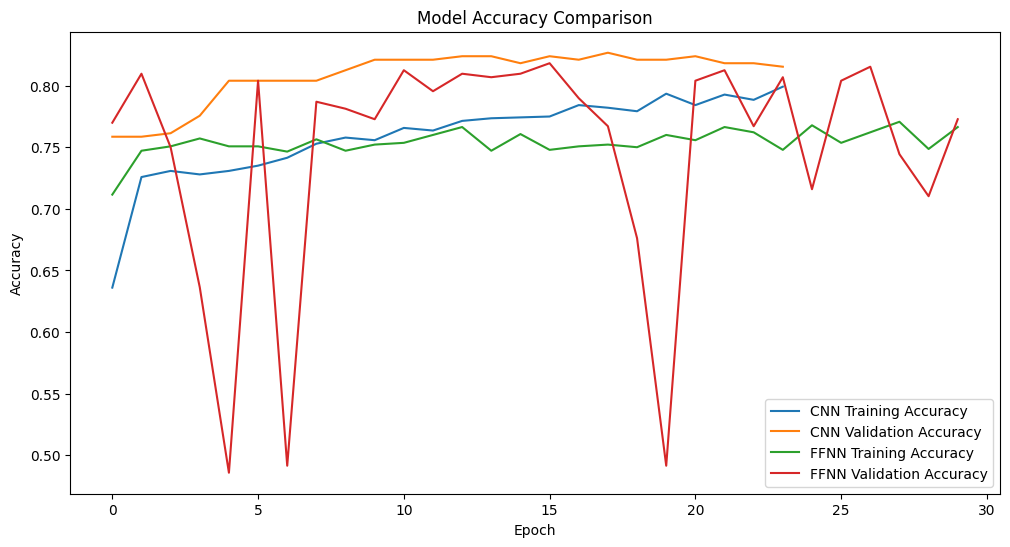

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(histories, labels):
    plt.figure(figsize=(12, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{label} Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_training_history([history, history_improved_ffnn], ['CNN', 'FFNN'])

# Justifying Multiple Parameters

### 1. Dataset Complexity
CNNs handle spatial hierarchies, making them suitable for image-like data.
FFNNs process tabular or non-spatial data effectively.

### 2. Flexibility
Different architectures ensure diverse feature representation and better generalization.

### 3. Hyperparameter Optimization
Dropout reduces overfitting; dense layers balance model complexity.

### 4. Performance Comparison
Metrics and confusion matrices highlight architecture strengths.

# Evaluate FFNN Performance

11/11 [==============================] - 0s 8ms/step
Classification Report for FFNN:
              precision    recall  f1-score   support

         0.0       0.59      0.89      0.71       171
         1.0       0.80      0.41      0.54       181

    accuracy                           0.64       352
   macro avg       0.70      0.65      0.63       352
weighted avg       0.70      0.64      0.62       352



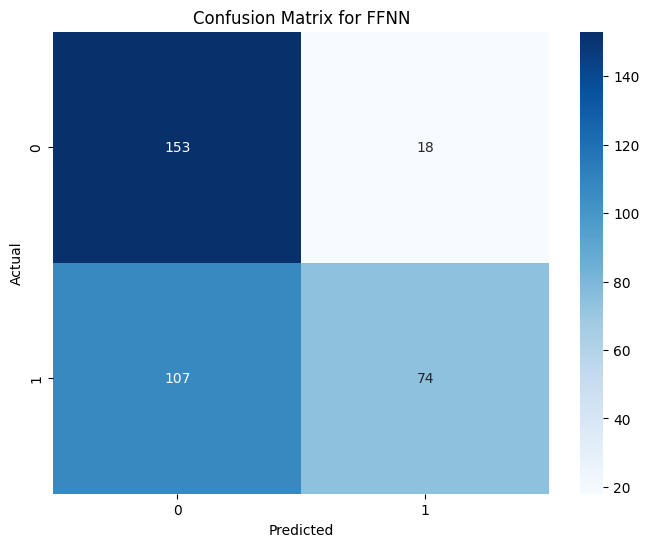

In [ ]:
y_pred_ffnn = (improved_ffnn.predict(X_test) > 0.5).astype('int32')

cm_ffnn = confusion_matrix(y_test, y_pred_ffnn)
print('Classification Report for FFNN:')
print(classification_report(y_test, y_pred_ffnn))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ffnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FFNN')
plt.show()

# Grad-CAM for CNN Interpretation

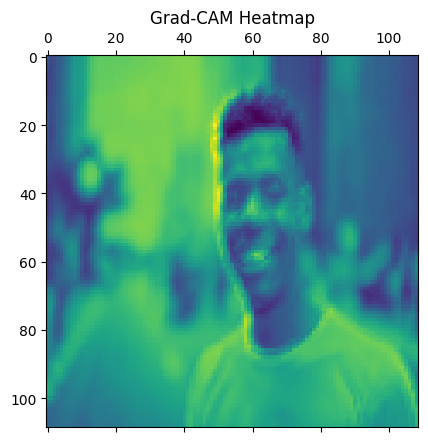

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def grad_cam(input_model, img_array, layer_name):
    with tf.GradientTape() as tape:
        model = Model(inputs=[input_model.input],
                      outputs=[input_model.get_layer(layer_name).output, input_model.output])
        conv_output, predictions = model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grad = tape.gradient(loss, conv_output)[0]
    pooled_grads = K.mean(grad, axis=(0, 1, 2))
    heatmap = np.mean(conv_output[0] * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

image_path = "/content/brazilian-boy-smiling.jpg"
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

heatmap = grad_cam(model, img_array, 'conv2d_1')
plt.matshow(heatmap)
plt.title('Grad-CAM Heatmap')
plt.show()

#Charts

##Class Distribution Before Data Augmentation

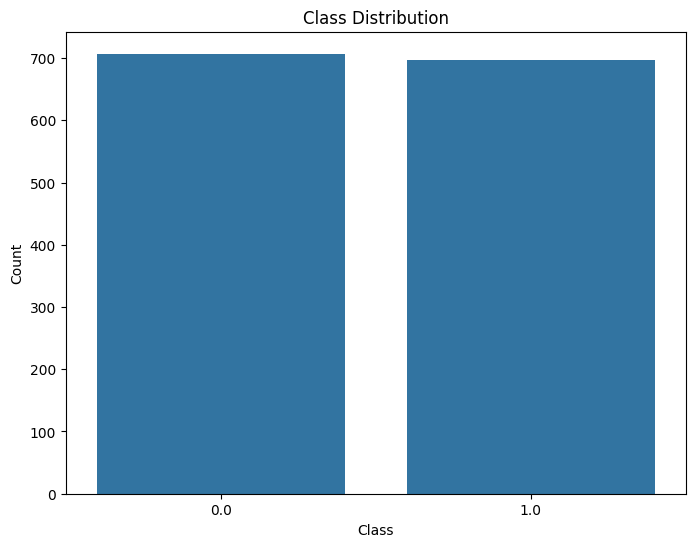

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

original_counts = Counter(y_train)

plt.figure(figsize=(8, 6))
sns.barplot(x=list(original_counts.keys()), y=list(original_counts.values()))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


##Class Distribution After Data Augmentation

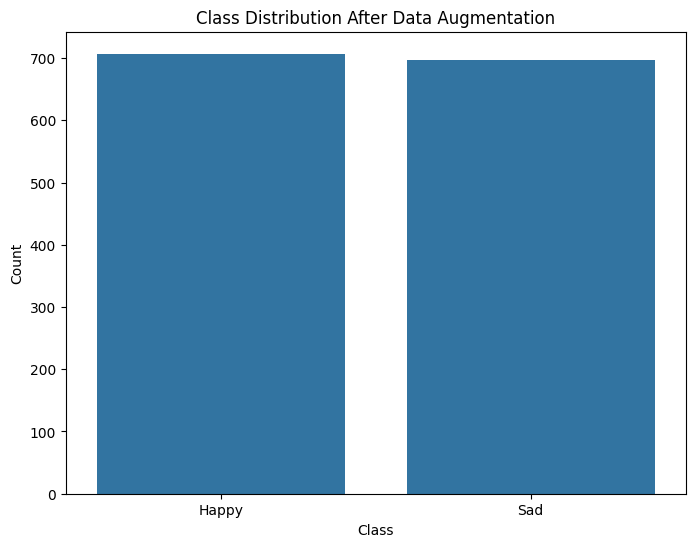

In [ ]:
augmented_counts = {"Happy": len(X_train[y_train == 0]), "Sad": len(X_train[y_train == 1])}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(augmented_counts.keys()), y=list(augmented_counts.values()))
plt.title('Class Distribution After Data Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


##Pixel Intensity Analysis (Histogram for RGB Channels)

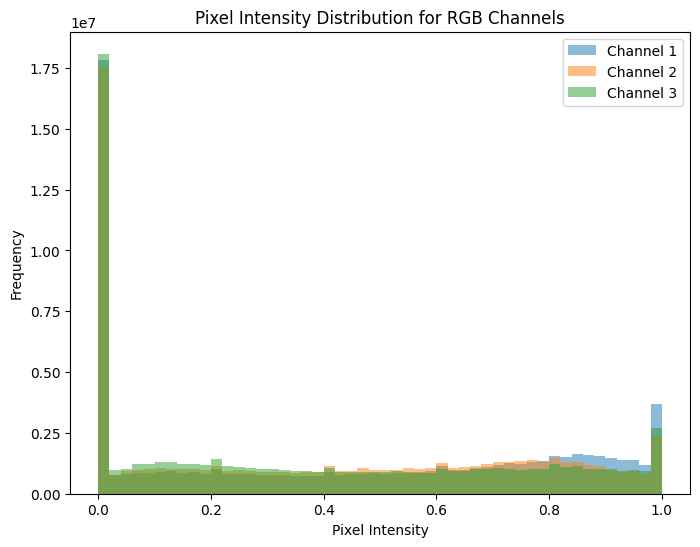

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.hist(X_train[:, :, :, i].ravel(), bins=50, alpha=0.5, label=f'Channel {i+1}')
plt.title('Pixel Intensity Distribution for RGB Channels')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


##Boxplots for Intensity Ranges

In [ ]:
# import numpy as np

# plt.figure(figsize=(8, 6))
# sns.boxplot(data=[X_train[:,:,:,i].ravel() for i in range(3)], palette='Set2')
# plt.title('Boxplot of Intensity Ranges for RGB Channels')
# plt.xticks(ticks=[0, 1, 2], labels=['Red', 'Green', 'Blue'])
# plt.xlabel('Color Channel')
# plt.ylabel('Pixel Intensity')
# plt.show()


##Scatter Plot for RGB Channel Distributions

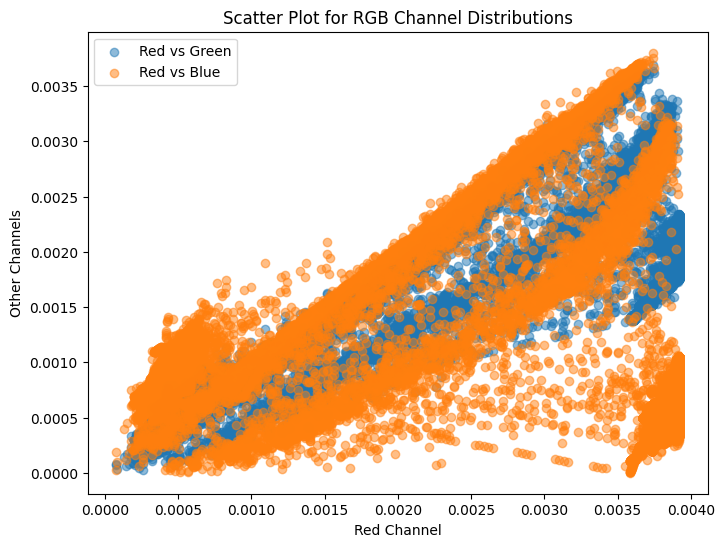

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[0][:,:,0].ravel(), X_train[0][:,:,1].ravel(), alpha=0.5, label='Red vs Green')
plt.scatter(X_train[0][:,:,0].ravel(), X_train[0][:,:,2].ravel(), alpha=0.5, label='Red vs Blue')
plt.title('Scatter Plot for RGB Channel Distributions')
plt.xlabel('Red Channel')
plt.ylabel('Other Channels')
plt.legend()
plt.show()


##CNN: Training vs. Validation Loss

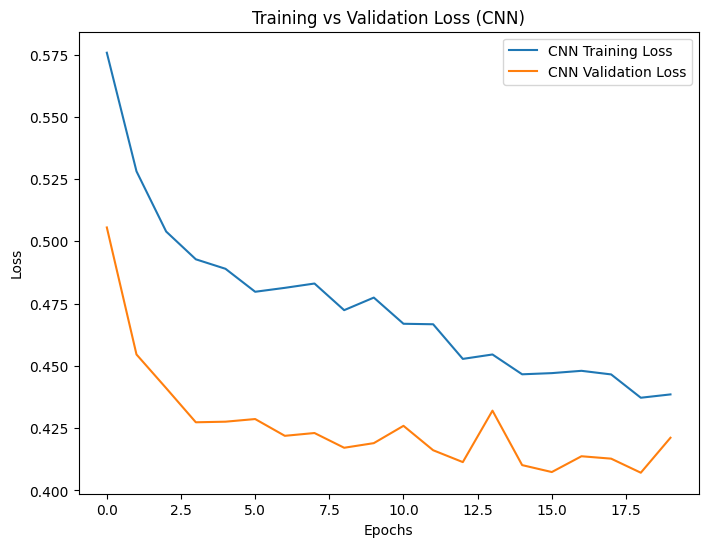

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='CNN Training Loss')
plt.plot(history.history['val_loss'], label='CNN Validation Loss')
plt.title('Training vs Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


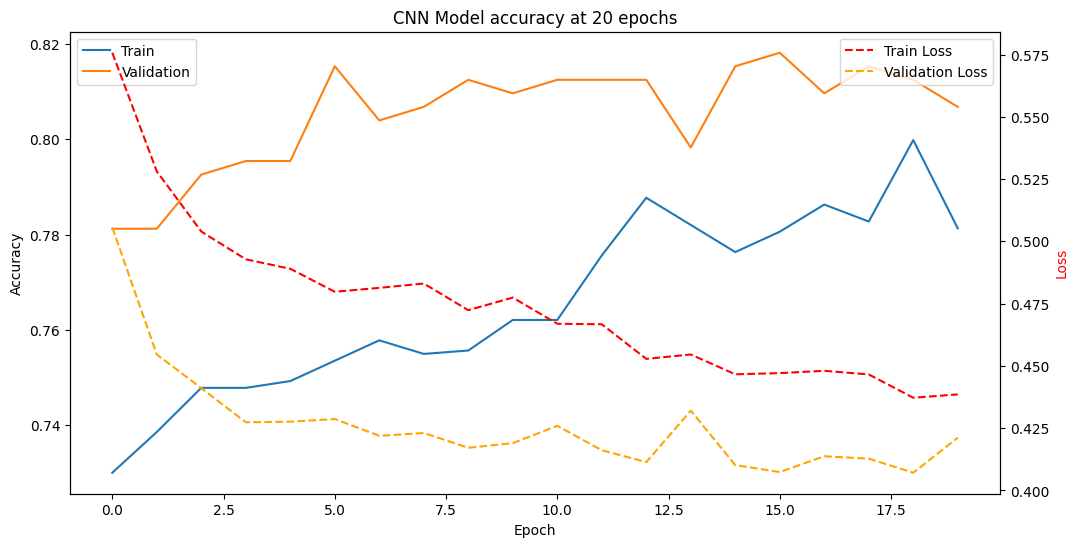

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy at 20 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values in the same plot
plt.twinx()  # Create a secondary y-axis
plt.plot(history.history['loss'], color='red', linestyle='--')
plt.plot(history.history['val_loss'], color='orange', linestyle='--')
plt.ylabel('Loss', color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

plt.show()

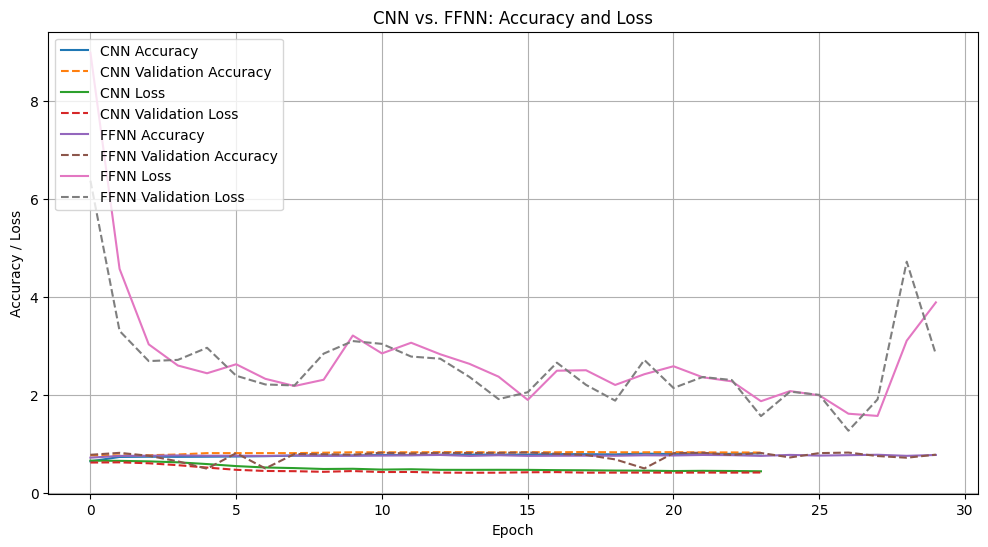

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot CNN accuracy and loss
plt.plot(history.history['accuracy'], label='CNN Accuracy', linestyle='-')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy', linestyle='--')
plt.plot(history.history['loss'], label='CNN Loss', linestyle='-')
plt.plot(history.history['val_loss'], label='CNN Validation Loss', linestyle='--')

# Plot FFNN accuracy and loss
plt.plot(history_improved_ffnn.history['accuracy'], label='FFNN Accuracy', linestyle='-')
plt.plot(history_improved_ffnn.history['val_accuracy'], label='FFNN Validation Accuracy', linestyle='--')
plt.plot(history_improved_ffnn.history['loss'], label='FFNN Loss', linestyle='-')
plt.plot(history_improved_ffnn.history['val_loss'], label='FFNN Validation Loss', linestyle='--')

# Customize the plot
plt.title('CNN vs. FFNN: Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='upper left')  # Adjust legend location as needed
plt.grid(True)

plt.show()

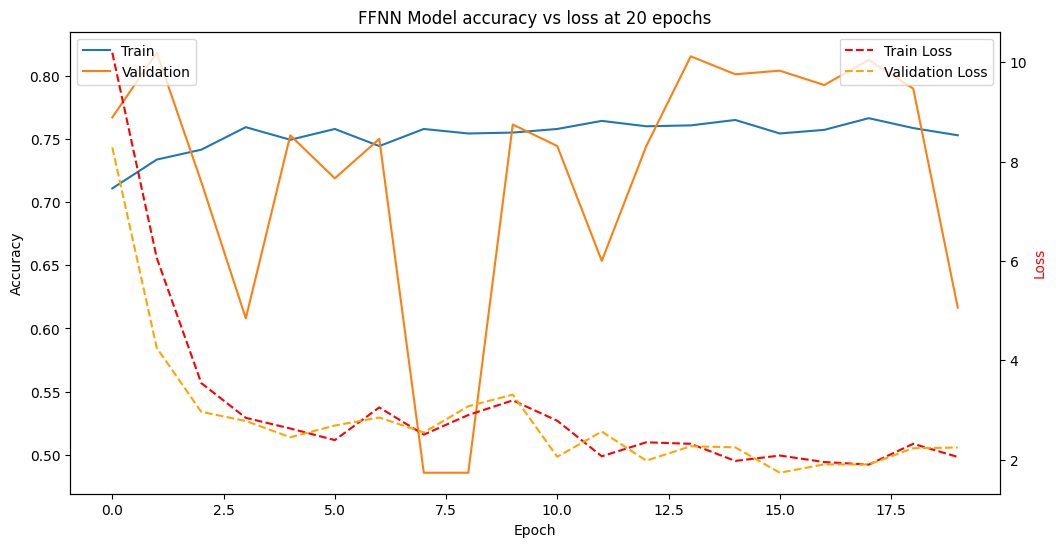

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.plot(history_improved_ffnn.history['accuracy'])
plt.plot(history_improved_ffnn.history['val_accuracy'])
plt.title('FFNN Model accuracy vs loss at 20 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values in the same plot
plt.twinx()  # Create a secondary y-axis
plt.plot(history_improved_ffnn.history['loss'], color='red', linestyle='--')
plt.plot(history_improved_ffnn.history['val_loss'], color='orange', linestyle='--')
plt.ylabel('Loss', color='red')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

plt.show()

##FFNN: Training vs. Validation Loss

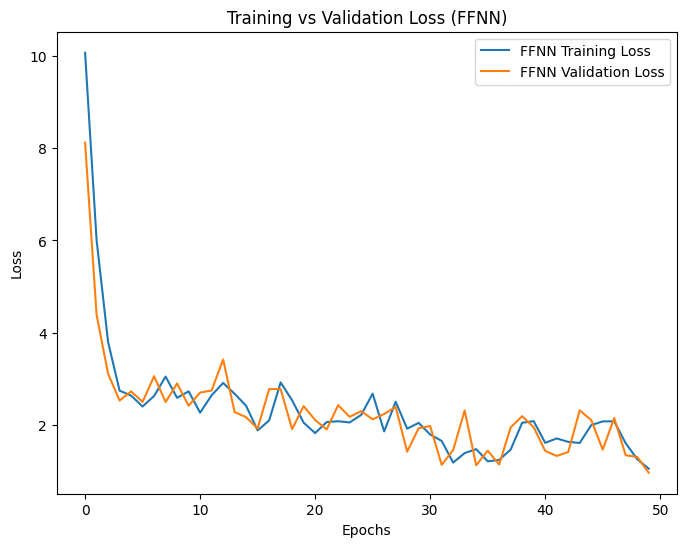

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history_improved_ffnn.history['loss'], label='FFNN Training Loss')
plt.plot(history_improved_ffnn.history['val_loss'], label='FFNN Validation Loss')
plt.title('Training vs Validation Loss (FFNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Combined Plot for CNN vs. FFNN:

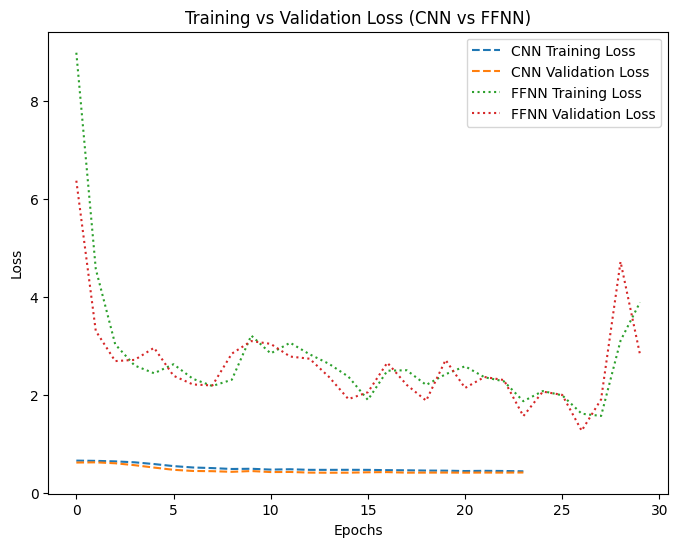

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='CNN Training Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='CNN Validation Loss', linestyle='--')
plt.plot(history_improved_ffnn.history['loss'], label='FFNN Training Loss', linestyle=':')
plt.plot(history_improved_ffnn.history['val_loss'], label='FFNN Validation Loss', linestyle=':')
plt.title('Training vs Validation Loss (CNN vs FFNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##CNN: Training vs. Validation Accuracy

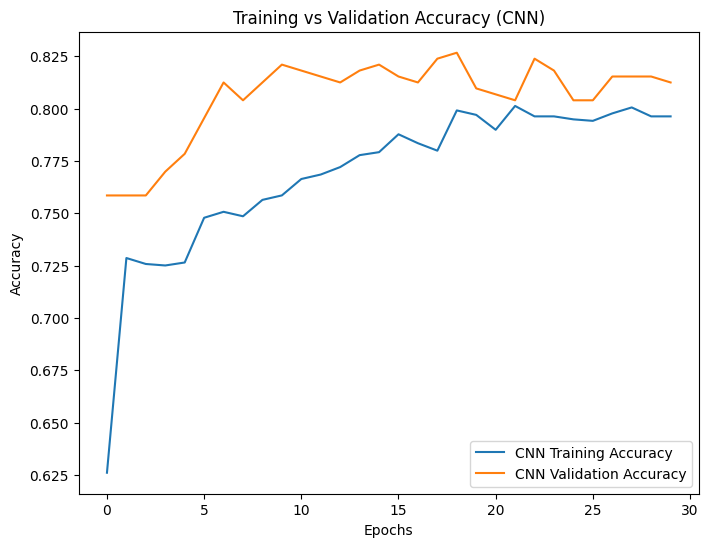

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('Training vs Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##FFNN: Training vs. Validation Accuracy

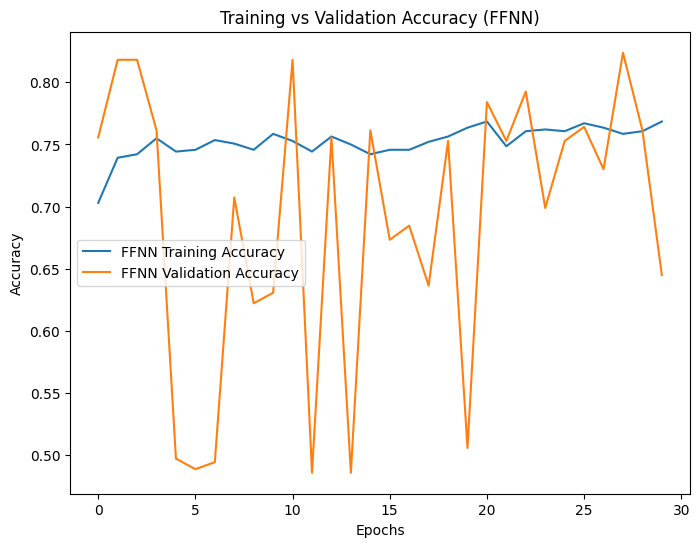

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history_improved_ffnn.history['accuracy'], label='FFNN Training Accuracy')
plt.plot(history_improved_ffnn.history['val_accuracy'], label='FFNN Validation Accuracy')
plt.title('Training vs Validation Accuracy (FFNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##Combined Plot: CNN vs. FFNN Accuracy

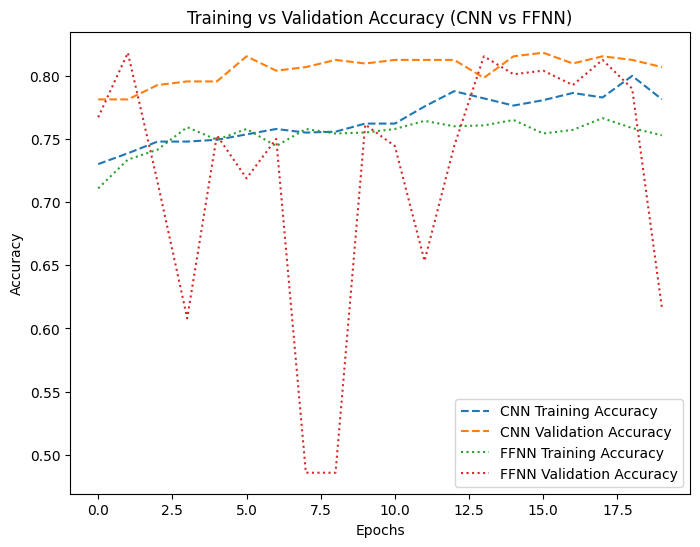

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='CNN Training Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy', linestyle='--')
plt.plot(history_improved_ffnn.history['accuracy'], label='FFNN Training Accuracy', linestyle=':')
plt.plot(history_improved_ffnn.history['val_accuracy'], label='FFNN Validation Accuracy', linestyle=':')
plt.title('Training vs Validation Accuracy (CNN vs FFNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##Confusion Matrix for CNN

11/11 [==============================] - 1s 105ms/step


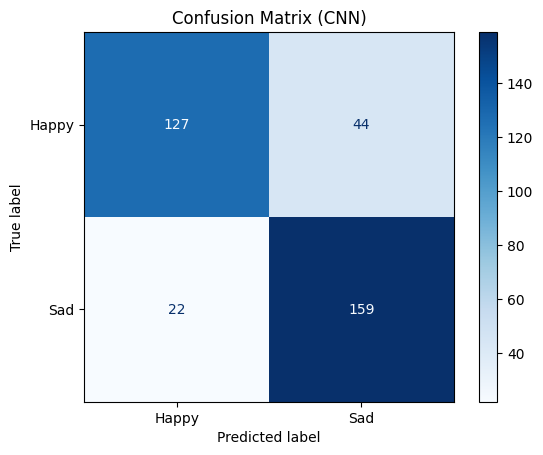

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Happy', 'Sad'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (CNN)')
plt.show()


##Confusion Matrix for FFNN

11/11 [==============================] - 0s 7ms/step


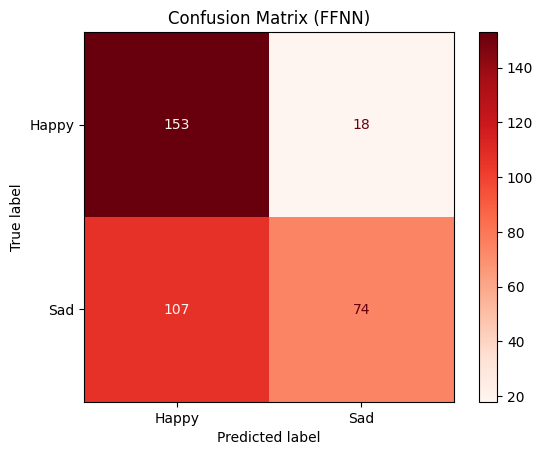

In [ ]:
ffnn_y_pred = (improved_ffnn.predict(X_test) > 0.5).astype('int32')
cm_ffnn = confusion_matrix(y_test, ffnn_y_pred)

disp_ffnn = ConfusionMatrixDisplay(confusion_matrix=cm_ffnn, display_labels=['Happy', 'Sad'])
disp_ffnn.plot(cmap='Reds')
plt.title('Confusion Matrix (FFNN)')
plt.show()

##Combined Confusion Matrices

11/11 [==============================] - 0s 8ms/step


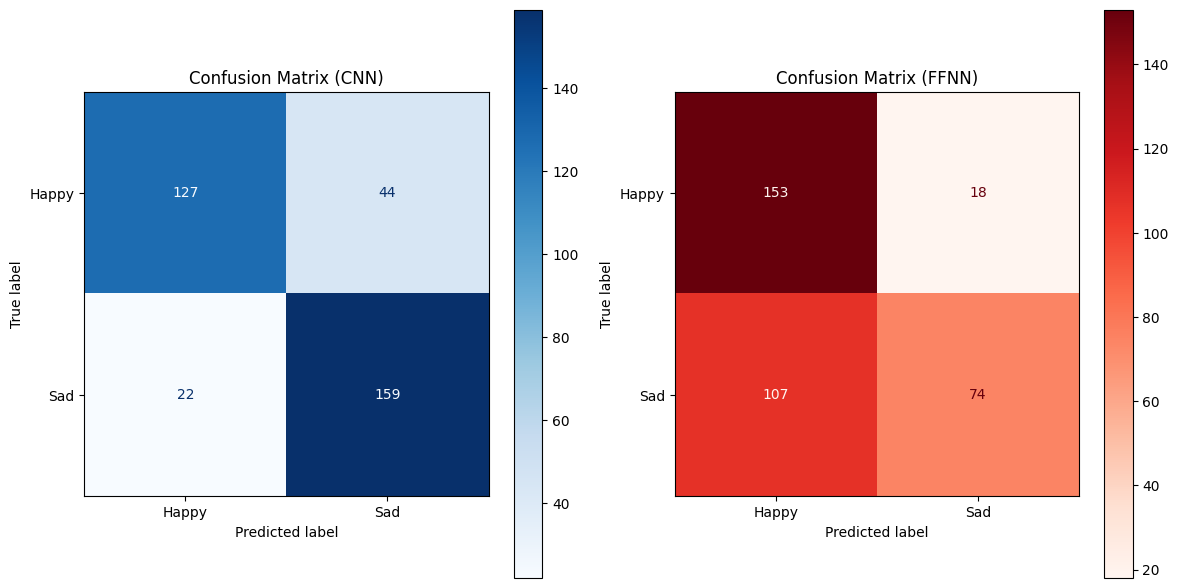

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cnn_y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm_cnn = confusion_matrix(y_test, cnn_y_pred)

ffnn_y_pred = (improved_ffnn.predict(X_test) > 0.5).astype("int32")
cm_ffnn = confusion_matrix(y_test, ffnn_y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=['Happy', 'Sad'])
disp_cnn.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (CNN)')

disp_ffnn = ConfusionMatrixDisplay(confusion_matrix=cm_ffnn, display_labels=['Happy', 'Sad'])
disp_ffnn.plot(ax=axes[1], cmap='Reds')
axes[1].set_title('Confusion Matrix (FFNN)')

plt.tight_layout()
plt.show()


##Performance Metrics Comparison Table

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

cnn_y_pred = (model.predict(X_test) > 0.5).astype("int32")
cnn_report = classification_report(y_test, cnn_y_pred, output_dict=True)

ffnn_y_pred = (improved_ffnn.predict(X_test) > 0.5).astype("int32")
ffnn_report = classification_report(y_test, ffnn_y_pred, output_dict=True)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Class 0)', 'Precision (Class 1)',
               'Recall (Class 0)', 'Recall (Class 1)',
               'F1-score (Class 0)', 'F1-score (Class 1)'],
    'CNN': [
        cnn_report['accuracy'],
        cnn_report['0.0']['precision'],
        cnn_report['1.0']['precision'],
        cnn_report['0.0']['recall'],
        cnn_report['1.0']['recall'],
        cnn_report['0.0']['f1-score'],
        cnn_report['1.0']['f1-score']
    ],
    'FFNN': [
        ffnn_report['accuracy'],
        ffnn_report['0.0']['precision'],
        ffnn_report['1.0']['precision'],
        ffnn_report['0.0']['recall'],
        ffnn_report['1.0']['recall'],
        ffnn_report['0.0']['f1-score'],
        ffnn_report['1.0']['f1-score']
    ]
})

print("Comparison of CNN and FFNN Performance Metrics")
print(comparison_df)

11/11 [==============================] - 0s 8ms/step
Comparison of CNN and FFNN Performance Metrics
                Metric       CNN      FFNN
0             Accuracy  0.812500  0.644886
1  Precision (Class 0)  0.852349  0.588462
2  Precision (Class 1)  0.783251  0.804348
3     Recall (Class 0)  0.742690  0.894737
4     Recall (Class 1)  0.878453  0.408840
5   F1-score (Class 0)  0.793750  0.709977
6   F1-score (Class 1)  0.828125  0.542125
